# Can we predict the usefulness of an amazon review?

On Amazon.com, products can be reviewed by buyers. To prospective buyers, the reviews provide helpful insights about a product, its possible defficiencies or good points. To amazon, they constitute a formidable selling tool: providing reviews attracts users to the amazon website and thus drives amazon's sells. 

The more helpful and interesting the reviews, the more prospective buyers will use the Amazon website. Therefore, it is amazon primary interest to detect useful reviews and make them stand-out on the web interface.

Currently, Amazon uses a user voting system where buyers and prospective buyers can upvote a review for its usefulness. But this introduces a lag between the moment the review is published and the moment when enough users have voted and the review is promoted.

So, can we speed up this process using machine learning? Our project attempts to do so.

## About the notebook

This notebook contains python code to parse a dataset of Amazon reviews using spark and predict the usefulness score using machine-learning.

## Current implementation

Because we run the code on a cluster for production but on the notebook during development, we need a way to detect which libraries to import. The following snippet does so.

In [247]:
#Detects wether we're running inside the dev notebook
try:
    get_ipython
    notebook = True
except:
    notebook = False
notebook

True

Here comes all our imports

In [249]:
if notebook:
    import findspark
    # TEMPORARY
    # findspark.init()
    findspark.init('/Users/yuliana/Desktop/ADA/spark')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkContext

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from datetime import datetime  
from datetime import timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json

Now, we load the dataset using spark

In [273]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

if notebook:
    dataFile = 'data/sample_us.csv'
else:
    dataFile = 'hdfs:///datasets/amazon_multiling/tsv/amazon_reviews_us*tsv.gz'

schema = StructType([
    StructField('marketplace', StringType()),
    StructField('customer_id', IntegerType()),
    StructField('review_id', StringType()),
    StructField('product_id', StringType()),
    StructField('product_parent', IntegerType()),
    StructField('product_title', StringType()),
    StructField('product_category', StringType()),
    StructField('star_rating', IntegerType()),
    StructField('helpful_votes', IntegerType()),
    StructField('total_votes', IntegerType()),
    StructField('vine', StringType()),
    StructField('verified_purchase', StringType()),
    StructField('review_headline', StringType()),
    StructField('review_body', StringType()),
    StructField('review_date', DateType()),
])

df = spark.read.csv(dataFile, header=True, schema=schema)

In [290]:
# query1 = '''
# SELECT * FROM df
#   INNER JOIN
#   (
#     SELECT product_id
#     FROM df
#     GROUP BY product_id
#   ) interesting
#   on df.product_id = interesting.product_id
#   WHERE df.total_votes > 1
# '''

query1 = '''
SELECT df.product_id, df.review_id, df.product_category, df.star_rating, df.helpful_votes, df.total_votes, df.customer_id, df.verified_purchase, df.review_body, df.review_date  FROM
  df
  INNER JOIN
  (
    SELECT customer_id
    FROM df
    GROUP BY customer_id
    HAVING COUNT(*) >= 30 
  ) interesting
  on df.customer_id = interesting.customer_id
  WHERE total_votes >= 10
'''

df.registerTempTable("df")
df_queried = spark.sql(query1)

In [291]:
df_queried.head(10)

[]

In [267]:
df_queried = df_queried.toPandas()

In [259]:
# df = pd.read_json('/Users/yuliana/Desktop/ADA/ADA2018-Homework/ADA-Project/data/final_query.json', lines=True)
# df = pd.read_json("final_query.json", lines=True)
# df.product_id.value_counts(ascending=False).head()

OSError: [Errno 22] Invalid argument

In [268]:
df_queried.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,product_id
0,US,43880421,R2ATXF4QQ30YW,B00000JS5S,341842639,Hot Wheels 48- Car storage Case With Easy Grip...,Toys,5,0,0,N,Y,Five Stars,awesome ! Thanks!,2015-08-31,B00000JS5S
1,US,43880421,R2ATXF4QQ30YW,B00000JS5S,341842639,Hot Wheels 48- Car storage Case With Easy Grip...,Toys,5,0,0,N,Y,Five Stars,awesome ! Thanks!,2015-08-31,B00000JS5S
2,US,11210951,R1W3QQZ8JKECCI,B003JT0L4Y,876626440,Ocean Life Stamps Birthday Party Supplies Loot...,Toys,5,0,0,N,Y,Fun for birthday party favor,I ordered these for my 3 year old son's birthd...,2015-08-31,B003JT0L4Y
3,US,11210951,R1W3QQZ8JKECCI,B003JT0L4Y,876626440,Ocean Life Stamps Birthday Party Supplies Loot...,Toys,5,0,0,N,Y,Fun for birthday party favor,I ordered these for my 3 year old son's birthd...,2015-08-31,B003JT0L4Y


In [240]:
df_queried.insert(5, 'helpfulness', df_queried.helpful_votes / df_queried.total_votes)
df_queried['helpfulness'] = df_queried['helpfulness'].round(1)
df_queried.insert(6, 'helpful', df_queried.helpfulness > 0.6)
df_queried['review_length'] = df_queried['review_body'].apply(len)
df_queried.head(10)

ValueError: cannot insert helpfulness, already exists

In [245]:
df_electronics = df_queried[df_queried.product_category == 'Electronics']
df_beauty = df_queried[df_queried.product_category == 'Beauty']
df_toys = df_queried[df_queried.product_category == 'Toys']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

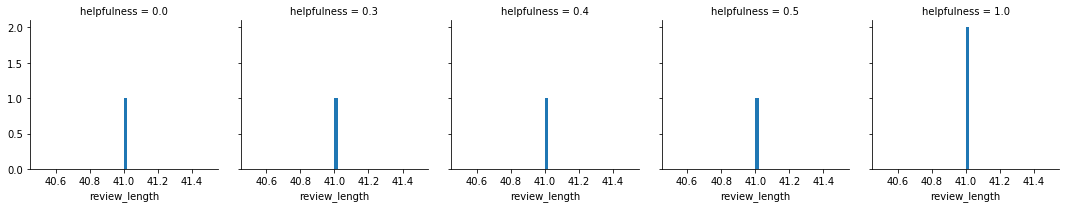

In [233]:
g = sns.FacetGrid(data=df_queried, col='helpfulness')
g.map(plt.hist, 'review_length', bins=50)

In [234]:
import string
import nltk
from nltk.corpus import stopwords
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [236]:
X = df_queried['review_body']
Y = df_queried['helpful']

from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer=text_process).fit(X)
X = bow_transformer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (6, 5)
Amount of Non-Zero occurrences:  30
Density: 100.0


In [237]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [238]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [239]:
preds = nb.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[1 0]
 [1 0]]


              precision    recall  f1-score   support

       False       0.50      1.00      0.67         1
        True       0.00      0.00      0.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/Users/yuliana/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yuliana/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yuliana/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
